In [1]:
import torch
import numpy as np
import cv2
import ipdb
import scipy
import math

# from torch import nn
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


from numpy import dot
from numpy.linalg import matrix_rank, inv
from numpy.random import permutation
from scipy.linalg import eigh
from scipy.linalg import norm as mnorm
from scipy.stats import ortho_group

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import os


import ica

from modules.util import entropyLoss, getdata, infomaxICA, entropy

In [2]:
np.random.seed(1005)
num_of_img = 2
# numbatch=100
# batchsize = int(35000/numbatch)
sub_shape = num_of_img

A = np.random.rand(num_of_img,num_of_img)
# A = np.random.normal(0, 1,(num_of_img,num_of_img))
# D = np.diag(np.array([1,100,200,300,400,500,600,700,800,900], dtype=float))

# B = ortho_group.rvs(dim=num_of_img)
# A = B @ D
print('condition number:', np.linalg.cond(A))
X_list = []
# X_list.append(np.random.standard_t(5, size=(1,16384)))
# X_list.append(np.random.laplace(scale=scale, size=(1,16384)))
# X_list.append(np.random.exponential(scale, size=(1,16384)))
for i in range(num_of_img):
    scale = np.random.randint(5,15)
#     print(scale)
#     X_list.append(np.random.beta(0.5,0.5,(1,16384)))
#     X_list.append(np.random.randn(1, 35000))
    X_list.append(np.random.laplace(scale=scale, size=(1,16384)))
#     X_list.append(np.random.standard_t(1, size=(1,16384)))
#     X_list.append(np.random.exponential(scale, size=(1,16384)))
#     X_list.append(np.random.chisquare(scale, size=(1,16384)))
    
dist_c = np.concatenate(X_list)


# unif = np.random.uniform(1,2,(10,numbatch))
# for i in range(numbatch):
#     dist_c[:,batchsize*i:batchsize*(i+1)] *= unif[:,i:i+1]

mixture = A@dist_c

condition number: 2.1632194913167555


In [3]:
# file_name = os.listdir('./data')
# dir_list = []
# for name in file_name[0:5]:
#     dir_list.append('./data/'+name)
# num_of_img = len(dir_list)
# # num_of_img = 3
# resize = 128

# array_list=[]

# for img_dir in dir_list:
#     image = Image.open(img_dir)
#     image = np.array(ImageOps.grayscale(image))
#     image = cv2.resize(image, (resize, resize))
# #     image = torch.from_numpy(image).float().flatten()
#     image = np.expand_dims(image.flatten(), axis=0)
#     array_list.append(image)

# img_concate = np.concatenate(array_list)
# np.random.seed(1)

# A = np.random.rand(num_of_img,num_of_img)
# mixture = A@img_concate

# print(A, img_concate.shape, sep='\n')

# print('condition number:', np.linalg.cond(A))


In [4]:
x_white, white, dewhite = ica.pca_whiten(mixture, num_of_img)

IPT = torch.from_numpy(x_white.copy()).type(torch.float32)

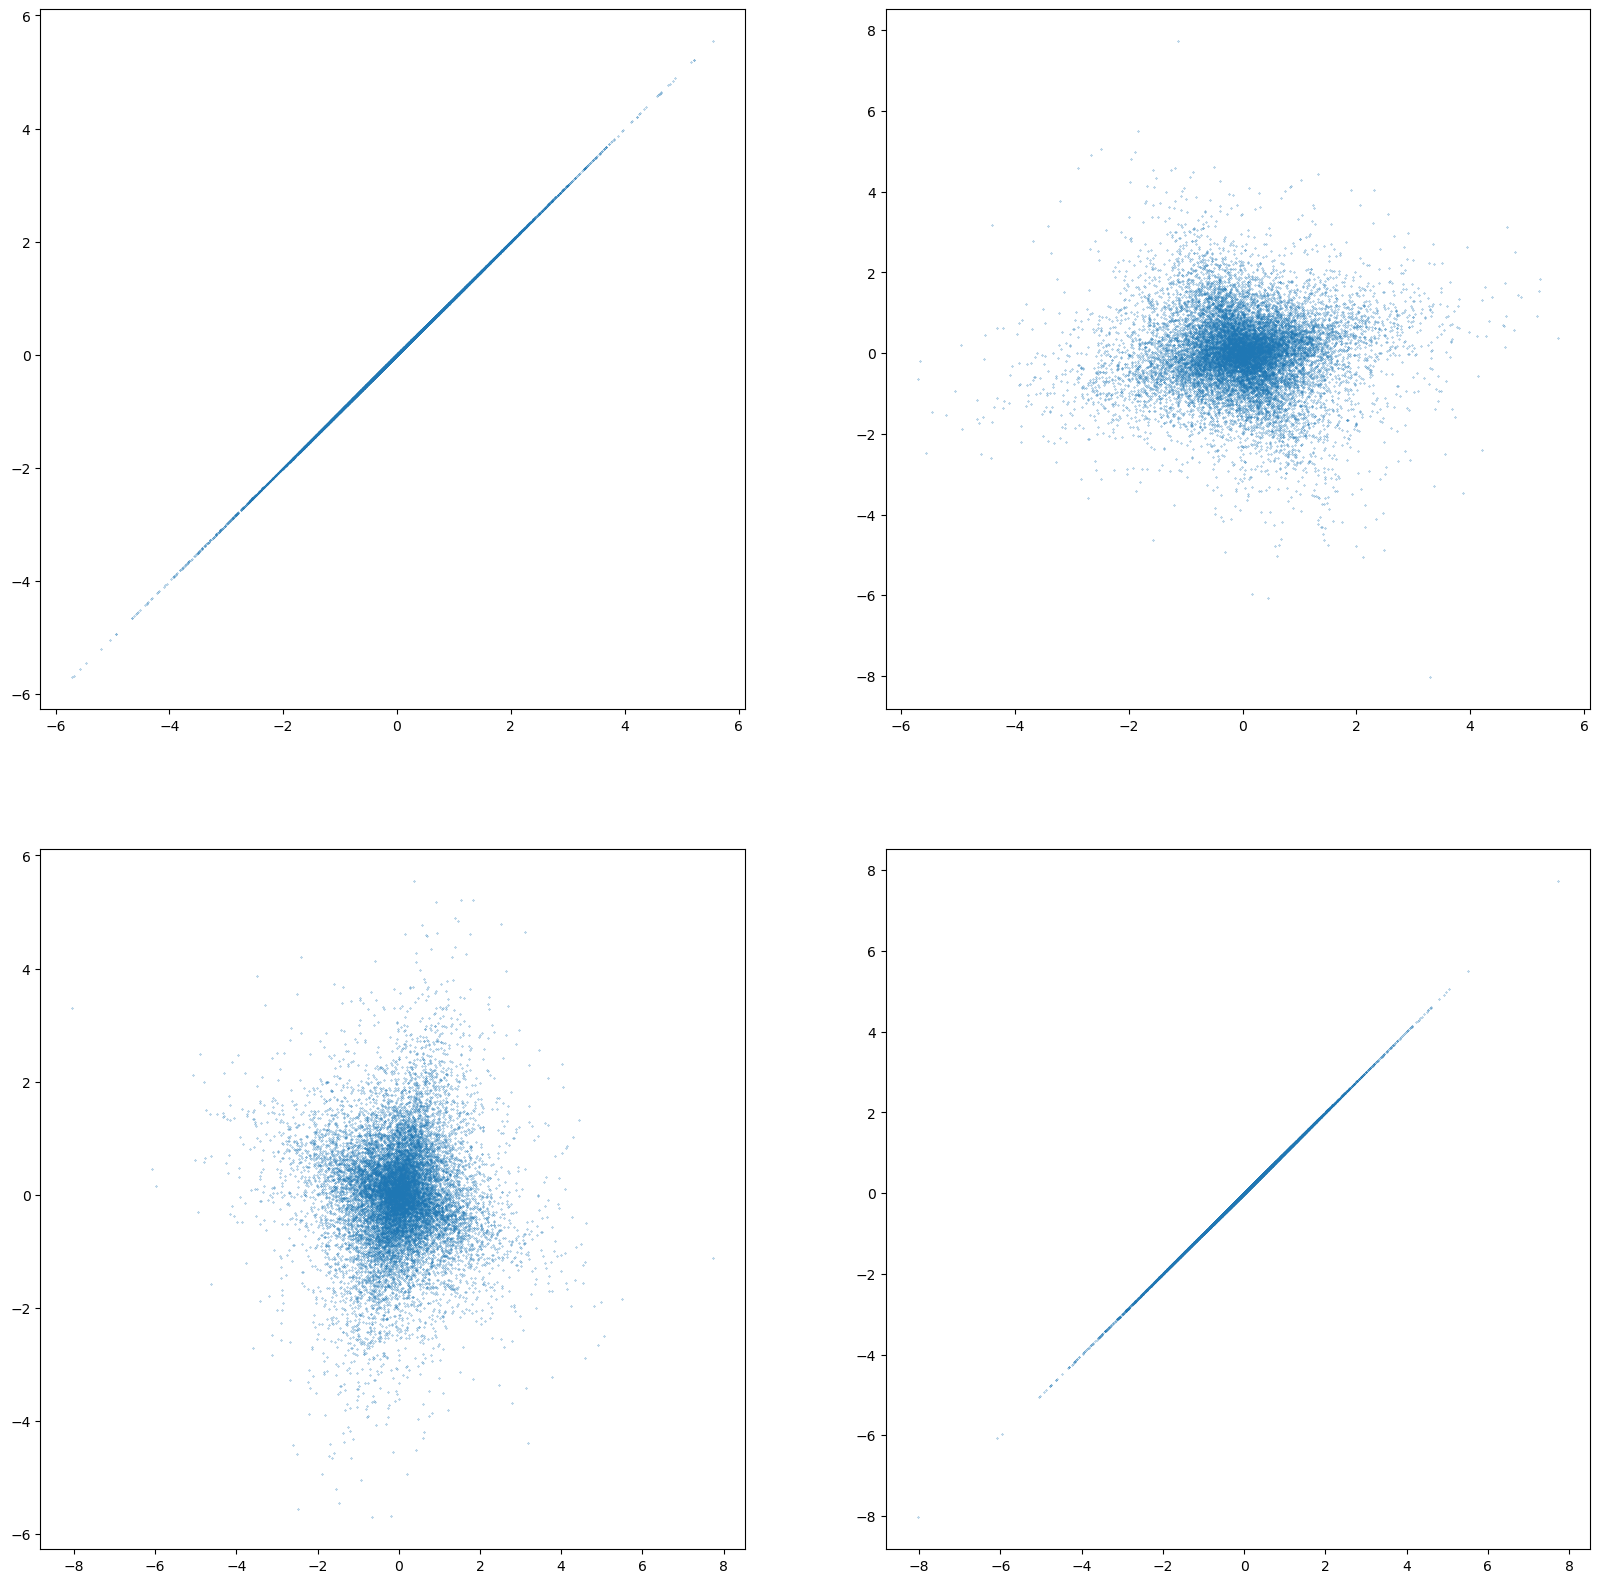

In [5]:
%matplotlib inline
plt.figure(figsize=(20,20))

index = num_of_img

for row in range(index):
    for column in range(index):
        plt.subplot(index, index, row*index + column+1)
        plt.plot(x_white[row], x_white[column], '.', ms=0.5)

In [6]:
device = torch.device('cuda:0')

In [7]:
model = infomaxICA(num_of_img)

In [8]:
# learning_rate = 0.03 / np.log(num_of_img)
learning_rate = 0.0001
# batch_size = int(np.floor(np.sqrt(IPT.shape[1] / 3)))
# batch_size = int(resize*resize)
batch_size = 128
dataset = getdata(IPT)
# sampler = SequentialSampler(dataset)
sampler = RandomSampler(dataset)
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size)

# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=learning_rate,
                             eps=10e-4,
                             weight_decay = 1e-4,
                            )


num_epoch = 5000
scheduler = CosineAnnealingLR(optimizer, T_max = num_epoch/2)
# scheduler = OneCycleLR(optimizer, 
#                        learning_rate, 
#                        steps_per_epoch=len(loader), 
#                        epochs=num_epoch,
#                       )

# np.linalg.inv(model.W1.weight.data)

In [9]:
model = model.to(device)
IPT = IPT.to(device)

In [10]:
loss_tracker = []

In [11]:
def angle2cart(a):
    # a should be in shape [t,d], d for number of dimensions, t for number of pixels
    d = a.shape[1]
    t = a.shape[0]

    r = [1]+[10*2**i for i in range(d-1)] # radii

    multi_sin = torch.sin(a)
    multi_tan = torch.tan(a)

    output = r[0] * multi_sin[:, 0:1] #for x1
    for j in range(1, d): #for x2 to xn
        output = torch.cat((output, (output[:,-1:]/multi_tan[:,j-1:j] + r[j]) * multi_sin[:, j:(j+1)]), 1)
    output = torch.cat((output, output[:, -1:] / multi_tan[:,-1:]), 1)  #for xn+1

    return output

In [12]:
def norm(x):
    """Computes the norm of a vector or the Frobenius norm of a
    matrix_rank
    """
    return torch.norm(torch.flatten(x))

<IPython.core.display.Javascript object>


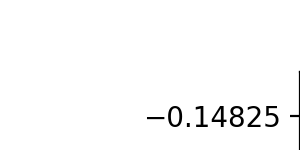

lr changed to: 9e-05
1 tensor(90.) -0.14823798835277557 tensor(0.0005, device='cuda:0')
2 tensor(1.5807) -0.1482546180486679 tensor(0.0004, device='cuda:0')
3 tensor(3.6933) -0.14828330278396606 tensor(0.0004, device='cuda:0')
4 tensor(4.5114) -0.14830845594406128 tensor(0.0003, device='cuda:0')
5 tensor(9.8920) -0.148326113820076 tensor(0.0003, device='cuda:0')
6 tensor(8.7972) -0.14834560453891754 tensor(0.0003, device='cuda:0')
7 tensor(7.1937) -0.14836420118808746 tensor(0.0003, device='cuda:0')
8 tensor(7.1382) -0.1483524590730667 tensor(0.0003, device='cuda:0')
9 tensor(16.2794) -0.1483612060546875 tensor(0.0002, device='cuda:0')
10 tensor(11.8171) -0.14837661385536194 tensor(0.0002, device='cuda:0')
11 tensor(19.9974) -0.14839839935302734 tensor(0.0002, device='cuda:0')
12 tensor(21.3444) -0.14839737117290497 tensor(0.0002, device='cuda:0')
13 tensor(20.3745) -0.14839518070220947 tensor(0.0002, device='cuda:0')
14 tensor(27.0599) -0.14841027557849884 tensor(0.0002, device='cuda:

In [13]:
%matplotlib notebook

k = int(batch_size*0.16)

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133, projection='3d')
# ax3 = fig.add_subplot(133)

# trace = []
change = 100
W_STOP = 1e-10
d_weigths = torch.zeros(num_of_img)
old_d_weights = torch.zeros([1, num_of_img])
torch_pi = torch.acos(torch.zeros(1)).item() * 2 

# for epoch in range(num_epoch):
step0 = 0
angle_delta = 0
while step0 < num_epoch and change > W_STOP:
# for i in range(1000):
    LOSS = 0
    old_weight = torch.clone(model.W1.weight.data)
    for step, ipt in enumerate(loader):
        model.zero_grad()
        ipt = ipt.to(device)
        
        opt = model.forward(ipt)
#------------------------------sphe2cartesin----------------------------------
        
        opt = angle2cart(opt)
#         opt = spher2cart(opt)
        
#---------------------------------------------------------------
#         loss = entropyLoss(opt.permute(1,0), device=device)
        loss = entropy(opt, k=k, dis=1)
        loss.backward()
        optimizer.step()
        LOSS+=loss
    d_weigths = model.W1.weight.data - old_weight
    change = norm(d_weigths)**2
    d_weigths = d_weigths.cpu()
    if step > 2:
        angle_delta = torch.arccos(
                    torch.sum(d_weigths * old_d_weights) /
                    (norm(d_weigths) * norm(old_d_weights) + 1e-8)
                ) * 180 / torch_pi
    if angle_delta > 60:
        learning_rate = learning_rate * 0.9
        
        print('lr changed to:', learning_rate)
        
        optimizer.param_groups[0]['lr'] = learning_rate
        old_d_weights = torch.clone(d_weigths)
    elif step == 1:
        old_d_weights = torch.clone(d_weigths)
        
        
        
    LOSS = LOSS.cpu()
    loss_tracker.append(LOSS.detach().numpy()/len(loader.sampler))
    if step0 % 2 == 0:
        
#         index = np.random.randint(0,num_of_img, 2)
        index = [0,1]
        ax.clear()
        ax.plot(loss_tracker[-100:])
        fig.canvas.draw()
    
        data1 = model.forward(IPT.T)
        data2 = angle2cart(data1)
        data2 = data2.cpu().detach().numpy()
        data1 = data1.cpu().detach().numpy()
        
#         data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
#         data2 = data.cpu().detach().numpy()
        ax1.clear()
        ax1.plot(data1[:, index[0]], data1[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        
        ax2.clear()
        ax2.scatter(data2[:,-1], data2[:,-2], data2[:,-3], c = 'r', s=0.1)

#         ax2.set_xlim3d(-2,2)
#         ax2.set_ylim3d(-2,2)
#         ax2.set_zlim3d(-2,2)
        ax2.set_xlim3d(-10,10)
        ax2.set_ylim3d(-10,10)
        ax2.set_zlim3d(-10,10)
        
        fig.canvas.draw()

#         ax3.clear()
        
#         ax3.plot(data[:, index[0]], data[:, index[1]], '.', ms=0.5)
#         fig.canvas.draw()
        

    

    step0 += 1
    print(step0, angle_delta, LOSS.detach().numpy()/len(loader.sampler), change)
    scheduler.step()

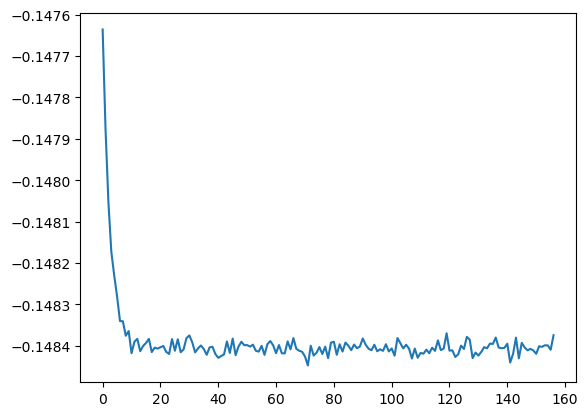

In [14]:
%matplotlib inline
plt.plot(loss_tracker)

In [15]:
mixer, b, unmixer = ica.ica1(mixture, ncomp=num_of_img, verbose=True)

Whitening data...
x_white shape: 2, 16384
Done.
Running INFOMAX-ICA ...
Beginning ICA training...
Step 62: Lrate 2.4e-05,Wchange 3.1e-07,Angle 40.54
Done.


In [16]:
model = model.cpu()
IPT = IPT.cpu()
data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()

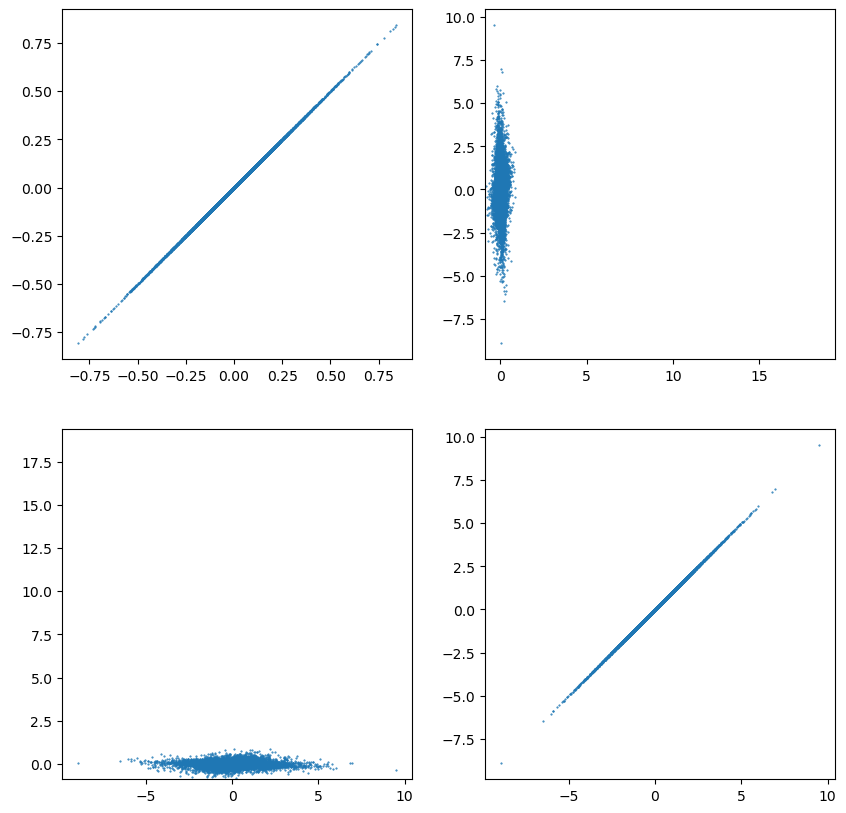

In [17]:
%matplotlib inline
# plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # plt.axis('square')
plt.figure(figsize=(10,10))
sub_shape = num_of_img
for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data[:, i], data[:, j], '.', ms=1)
        plt.axis('square')

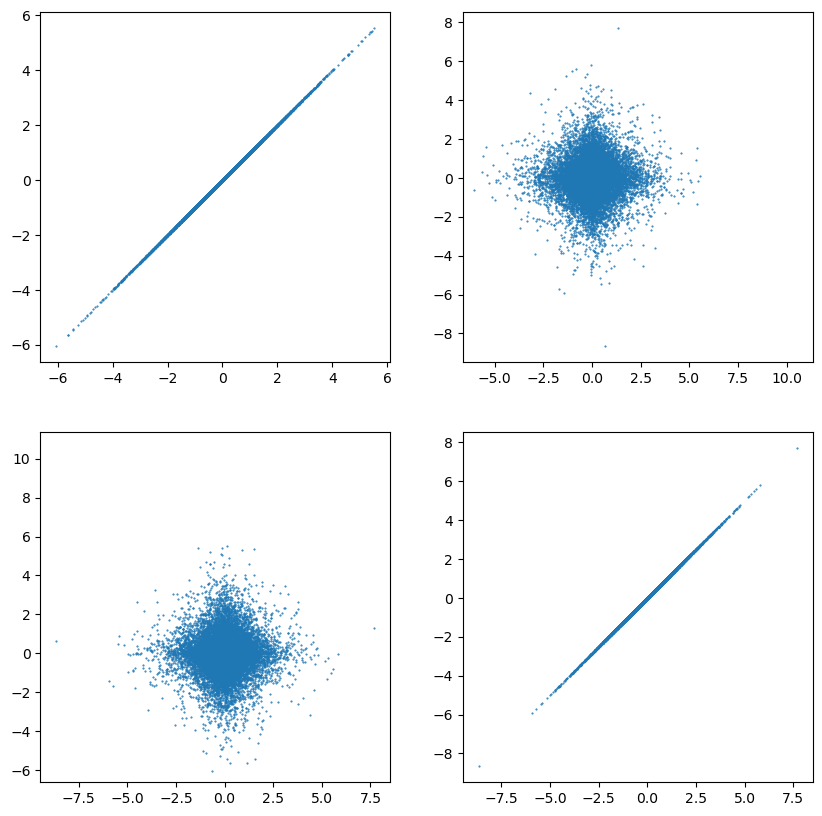

In [18]:
%matplotlib inline
# plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # plt.axis('square')
plt.figure(figsize=(10,10))
sub_shape = num_of_img
for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(b[i], b[j], '.', ms=1)
        plt.axis('square')

In [19]:
map_k_i = np.corrcoef(data.T, b)
map_k_white = np.corrcoef(data.T, x_white)
map_i_white = np.corrcoef(b, x_white)

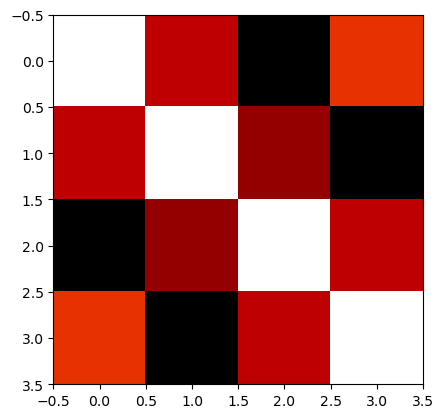

In [20]:
plt.imshow(map_k_i, cmap='gist_heat')

In [21]:
entropy(data, k=k)

tensor(-12.3700)

In [22]:
entropy(b.T, k=k)

tensor(-12.3155)